### TODO

1. Experiment with normalization
    - fit on train and just apply on test
    - try MinMax, 
    - try a different normalization model for each stock
2. Change predict length
    - try predicting a week in advance
3. Try trend classification
    - this would be an easier task than the regression on price
4. Formulate the problem of predicting change in price instead of raw price

## Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard

from indicators import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '4y'

## Load data

In [3]:
top100tech = ['AAPL', 'MSFT', 'TSM', 'NVDA', 'INTC', 'ASML', 'ADBE', 'CRM', 'AVGO', 'ORCL', 'CSCO', 'ACN', 'TXN', 'SHOP', 'QCOM', 'SAP', 'SNE', 'AMAT', 'INTU', 'NOW', 'SQ', 'IBM', 'MU', 'AMD',
'UBER', 'FIS', 'LRCX', 'FISV', 'SNOW', 'INFY', 'TEAM', 'ADSK', 'DELL', 'WDAY', 'VMW', 'ADI', 'NXPI', 'KLAC',
'CRWD', 'PLTR', 'DOCU', 'TEL', 'ERIC', 'MCHP', 'CDNS', 'CTSH',
'APH', 'SNPS', 'HPQ',
'PANW', 'OKTA','RNG','STM','MRVL','XLNX','WIT','MSI','SWKS','GLW','DDOG','ANSS','U','ZS','FTNT','STNE','ZBRA','KEYS','FTV','MXIM','COUP','GRMN','SPLK','HUBS','WORK','NET','FLT','CDW','CAJ','AFRM','PAYC','TER',
'VRSN','WDC', 'ZI',
'UMC','ANET','EPAM',
'UI','XM',
'GIB','TRMB',
'TYL','WIX','HPE','LYFT',
'LOGI',
'MPWR']

In [4]:
top10tech = top100tech[:10]

In [5]:
def process_stock_data_from_yf(data):
    
    df = pd.melt(data, ignore_index=False)
    df.columns = ['Variable', 'Ticker', 'Value']
    # this is a nicely formed dataframe of historical data
    nice_df = df.reset_index().pivot(index=['Ticker', 'Date'], columns=['Variable'], values=['Value'])
    nice_df.columns = nice_df.columns.droplevel()
    df = nice_df.reset_index()
    df.columns.name=None
    return df
    
    

In [6]:
data = yf.download(tickers = ' '.join(top10tech),
                   auto_adjust=True,
                  period=time_period)

[*********************100%***********************]  10 of 10 completed


In [7]:
data.shape

(1006, 50)

In [8]:
df = process_stock_data_from_yf(data)
df.head()

,Ticker,Date,Close,High,Low,Open,Volume
0,AAPL,2017-03-30,34.175156,34.310500,34.073057,34.236893,84829200.0
1,AAPL,2017-03-31,34.111042,34.255882,33.956702,34.125288,78646800.0
2,AAPL,2017-04-03,34.120541,34.220266,33.966204,34.122917,79942800.0
3,AAPL,2017-04-04,34.374607,34.403099,33.994697,34.013693,79565600.0
4,AAPL,2017-04-05,34.196522,34.538440,34.146657,34.244010,110871600.0


In [9]:
df[df['Ticker']=='CRWD'].isna()

,Ticker,Date,Close,High,Low,Open,Volume


In [10]:
crwd = df[df['Ticker']=='CRWD']

In [11]:
crwd

,Ticker,Date,Close,High,Low,Open,Volume


In [12]:
# check all nan values are in a continguous block. 
crwd[crwd['Close'].isna()].index.tolist() == list(range(18126, 18688))

False

In [13]:
tickers_with_all_data = df.groupby("Ticker").apply(lambda x: x.isna().sum()).max(axis=1)==0

In [14]:
print("{:.2f}% of companies had the required length of historical data. ".format(tickers_with_all_data.mean()*100))

100.00% of companies had the required length of historical data. 


In [15]:
tickers_with_all_data_list = tickers_with_all_data[tickers_with_all_data].index.tolist()

In [16]:
'AFRM' in tickers_with_all_data_list

False

In [17]:
df = df[df['Ticker'].isin(tickers_with_all_data_list)]

In [18]:
df.groupby("Ticker").apply(lambda x: x.isna().sum()).max(axis=1)

Ticker
AAPL    0
ADBE    0
ASML    0
AVGO    0
CRM     0
INTC    0
MSFT    0
NVDA    0
ORCL    0
TSM     0
dtype: int64

In [19]:
# nan_days = sum(data.isna().sum(axis=1)>0)
# if nan_days >1:
#     print("WARNING: there are {} days with missing data".format(nan_days))
# data = data.dropna()

In [20]:
df.groupby("Ticker").apply(np.mean).head()

c:\users\david jiang\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3370: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,Close,High,Low,Open,Volume
Ticker,,,,,
AAPL,62.767888,63.458051,62.022035,62.743130,1.286301e+08
ADBE,289.585209,292.941252,285.721471,289.592764,2.903278e+06
ASML,248.434462,250.861827,245.757788,248.338790,8.376520e+05
AVGO,266.098151,269.348885,262.650544,266.049938,2.962339e+06
CRM,153.196252,155.049821,151.136193,153.255219,6.019309e+06


In [21]:
df.isna().sum().sum()

0

### Compute Technical Markers

In [22]:
# compute all our technical markers for each of the stocks. 
dataset = df.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

### Filter to only one stock

In [23]:
# dataset = dataset.loc[dataset['Ticker']=='MSFT']

In [24]:
dataset

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-30,34.175156,34.310500,34.073057,34.236893,84829200.0,34.310500,34.073057,8.482920e+07,34.175156,NaN,-57.000732,0.237443,0.000000,0.000000,34.175156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-31,34.111042,34.255882,33.956702,34.125288,78646800.0,34.310500,33.956702,8.173800e+07,34.143099,0.045335,-48.412372,0.268312,-0.054618,-0.116355,34.140809,NaN,34.233769,34.052428,755.126024,751.126024,NaN,NaN,36.109567,-20.356004,-43.365599,36.109567,-0.187603,-0.001145,-36.083516
2,AAPL,2017-04-03,34.120541,34.220266,33.966204,34.122917,79942800.0,34.310500,33.956702,8.113960e+07,34.135579,0.034601,-39.252456,0.263562,-0.035616,0.009502,34.133066,NaN,34.204782,34.066376,988.534885,984.534885,NaN,NaN,172.775066,-13.513388,3.605306,104.442316,-0.159809,-0.001234,-54.389731
3,AAPL,2017-04-04,34.374607,34.403099,33.994697,34.013693,79565600.0,34.403099,33.956702,8.074610e+07,34.195336,0.122808,-6.976455,0.299772,0.182833,0.028493,34.206961,NaN,34.440952,33.949721,280.446193,276.446193,NaN,NaN,73.034207,60.990684,9.504838,93.972946,0.583615,0.005999,1.288992
4,AAPL,2017-04-05,34.196522,34.538440,34.146657,34.244010,110871600.0,34.538440,33.956702,8.677120e+07,34.195573,0.106356,-87.272391,0.318174,0.135341,0.151960,34.204237,NaN,34.408285,33.982862,323.520204,319.520204,NaN,NaN,5.784577,42.536779,47.760070,71.925854,0.062519,0.004295,61.418595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10055,TSM,2021-03-23,114.889999,116.750000,114.620003,116.099998,8977400.0,122.687740,112.984304,1.319561e+07,116.630659,2.495644,-87.324085,4.667189,-1.580002,-0.169998,118.071087,116.741885,121.621947,111.639371,48.733693,44.733693,122.191614,42.384512,80.571638,-33.853396,-3.642411,748.349121,-6.157634,-2.569497,-16.841042
10056,TSM,2021-03-24,108.959999,114.690002,108.849998,112.470001,24196100.0,120.844681,108.849998,1.318361e+07,116.188080,3.221199,-98.116429,4.411207,-2.059998,-5.770004,116.856275,116.879481,122.630477,109.745682,38.069827,34.069827,121.208440,36.552718,47.381939,-46.699181,-130.803298,749.352592,-5.380621,-2.978752,-60.958389
10057,TSM,2021-03-25,110.449997,112.750000,107.889999,108.000000,16772400.0,120.794870,107.889999,1.313735e+07,115.481183,3.322723,-47.325160,4.337080,-1.940002,-0.959999,116.002105,116.230764,122.126629,108.835736,36.754979,32.754979,120.262505,38.830163,33.793201,-44.730616,-22.134689,83.752167,-8.223385,-3.185679,-69.035511
10058,TSM,2021-03-26,116.559998,116.699997,111.199997,112.000000,12833600.0,120.794870,107.889999,1.282547e+07,115.699587,3.282900,-2.545443,4.264037,3.949997,3.309998,116.076491,116.523730,122.265386,109.133787,37.243106,33.243106,119.464934,47.199869,8.815425,92.635154,77.625916,79.403506,2.693914,-2.930066,-23.686236


### Quick visualizations

<AxesSubplot:xlabel='Date'>

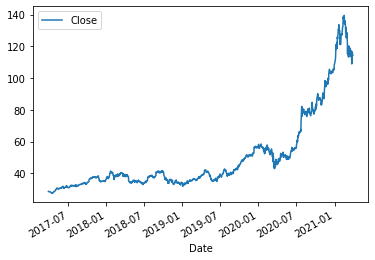

In [25]:
dataset.loc[dataset['Ticker']=='TSM', ['Date', 'Close']].set_index('Date').plot()

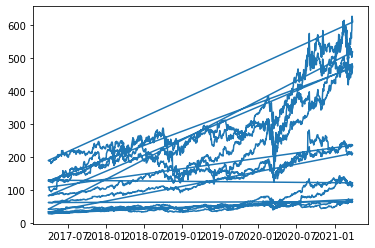

In [26]:
plt.plot('Date', 'Close', data=dataset)

In [27]:
dataset.shape

(10060, 31)

In [28]:
dataset.head(6)

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-30,34.175156,34.310500,34.073057,34.236893,84829200.0,34.310500,34.073057,8.482920e+07,34.175156,NaN,-57.000732,0.237443,0.000000,0.000000,34.175156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-31,34.111042,34.255882,33.956702,34.125288,78646800.0,34.310500,33.956702,8.173800e+07,34.143099,0.045335,-48.412372,0.268312,-0.054618,-0.116355,34.140809,NaN,34.233769,34.052428,755.126024,751.126024,NaN,NaN,36.109567,-20.356004,-43.365599,36.109567,-0.187603,-0.001145,-36.083516
2,AAPL,2017-04-03,34.120541,34.220266,33.966204,34.122917,79942800.0,34.310500,33.956702,8.113960e+07,34.135579,0.034601,-39.252456,0.263562,-0.035616,0.009502,34.133066,NaN,34.204782,34.066376,988.534885,984.534885,NaN,NaN,172.775066,-13.513388,3.605306,104.442316,-0.159809,-0.001234,-54.389731
3,AAPL,2017-04-04,34.374607,34.403099,33.994697,34.013693,79565600.0,34.403099,33.956702,8.074610e+07,34.195336,0.122808,-6.976455,0.299772,0.182833,0.028493,34.206961,NaN,34.440952,33.949721,280.446193,276.446193,NaN,NaN,73.034207,60.990684,9.504838,93.972946,0.583615,0.005999,1.288992
4,AAPL,2017-04-05,34.196522,34.538440,34.146657,34.244010,110871600.0,34.538440,33.956702,8.677120e+07,34.195573,0.106356,-87.272391,0.318174,0.135341,0.151960,34.204237,NaN,34.408285,33.982862,323.520204,319.520204,NaN,NaN,5.784577,42.536779,47.760070,71.925854,0.062519,0.004295,61.418595
5,AAPL,2017-04-06,34.111042,34.315243,34.061177,34.260629,84596000.0,34.538440,33.956702,8.640867e+07,34.181485,0.101194,-80.373339,0.307489,-0.223197,-0.085480,34.182673,NaN,34.383873,33.979097,339.782326,335.782326,NaN,NaN,44.615374,-72.586928,-27.799256,66.463758,-0.187603,0.000315,2.953790


In [29]:
dataset.describe()

,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
count,10060.000000,10060.000000,10060.000000,10060.000000,1.006000e+04,10060.000000,10060.000000,1.006000e+04,10060.000000,10050.000000,1.006000e+04,10060.000000,10060.000000,10060.000000,10060.000000,9930.000000,10050.000000,10050.000000,10050.000000,10050.000000,9930.000000,9920.000000,1.004900e+04,10060.000000,10060.000000,1.005000e+04,10060.000000,10060.000000,10050.000000
mean,156.314647,158.189321,154.283624,156.312800,2.340005e+07,163.481163,145.753161,2.336183e+07,155.021623,4.409156,-4.693857e+01,4.369006,0.206345,0.200303,155.024112,155.530691,163.911066,146.274441,56.419043,52.419043,154.685470,55.434978,2.520226e+04,6.401714,5.716375,2.532915e+04,1.837702,1.387167,14.292872
std,120.817691,122.463699,119.015077,120.866526,4.132041e+07,126.885086,111.803301,3.871170e+07,119.445048,4.954651,3.075493e+01,4.606816,3.931509,4.134078,119.385618,119.431841,127.124636,112.173880,48.981061,48.981061,118.612967,11.503978,1.969486e+06,66.846188,69.957821,5.258798e+05,7.097530,4.083208,51.279301
min,27.367176,27.583618,27.263282,27.497040,1.913000e+05,28.700474,27.263282,3.611000e+05,27.984349,0.034601,-1.000000e+02,0.237443,-43.387152,-46.946157,27.832838,27.877570,28.618188,26.824435,8.037656,4.037656,28.102601,18.890778,0.000000e+00,-449.429295,-544.397699,9.232525e-04,-38.722399,-25.660663,-175.465054
25%,51.170811,51.815740,50.693541,51.227579,3.092750e+06,53.451252,48.475446,3.337752e+06,51.106118,1.100275,-7.400846e+01,1.089338,-0.699997,-0.690199,51.009799,51.199181,53.361255,48.662205,32.743945,28.743945,51.038398,47.721817,1.509710e+01,-30.975783,-31.635884,5.521231e+01,-1.804938,-0.113468,-25.947586
50%,133.432571,134.992000,131.665001,133.608455,8.787450e+06,138.389999,125.540793,9.243468e+06,132.755001,2.656852,-4.561428e+01,2.937143,0.094359,0.164786,132.745768,134.093059,138.428299,125.198496,47.025936,43.025936,133.581506,55.665000,3.600001e+01,5.638412,10.213799,8.206023e+01,2.099376,0.698131,24.294375
75%,220.274120,223.347981,216.965860,220.171996,2.201108e+07,231.832629,206.142236,2.307572e+07,219.575077,5.963559,-1.847232e+01,5.855958,1.073922,1.210898,219.187116,220.270276,233.217103,206.713373,68.626218,64.626218,219.375691,63.604632,7.977609e+01,42.801915,47.047409,1.429322e+02,5.838977,2.595983,55.291003
max,625.669983,627.299988,601.460022,614.764404,4.268848e+08,627.299988,559.659973,3.155055e+08,582.634290,41.908829,1.843275e-12,34.143489,59.619995,38.669998,579.551148,589.851623,635.333070,554.851308,1669.263997,1665.263997,574.697402,92.784083,1.965605e+08,607.968514,432.043602,1.404010e+07,53.437238,30.346531,162.709976


In [30]:
tickers = dataset['Ticker'].unique()

In [31]:
dataset.isna().sum()

Ticker        0
Date          0
Close         0
High          0
Low           0
Open          0
Volume        0
HH            0
LL            0
AV            0
SMA           0
SD           10
WILLR         0
ATR           0
DMH           0
DML           0
EMA           0
WMA         130
BBHIGH       10
BBLOW        10
PERBHIGH     10
PERBLOW      10
TRIMA       130
RSI         140
DX           11
PDI           0
NDI           0
ADX          10
ROC           0
MACD          0
CCI          10
dtype: int64

### Choose features

In [32]:
dataset.head()

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-30,34.175156,34.310500,34.073057,34.236893,84829200.0,34.310500,34.073057,84829200.0,34.175156,NaN,-57.000732,0.237443,0.000000,0.000000,34.175156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
1,AAPL,2017-03-31,34.111042,34.255882,33.956702,34.125288,78646800.0,34.310500,33.956702,81738000.0,34.143099,0.045335,-48.412372,0.268312,-0.054618,-0.116355,34.140809,NaN,34.233769,34.052428,755.126024,751.126024,NaN,NaN,36.109567,-20.356004,-43.365599,36.109567,-0.187603,-0.001145,-36.083516
2,AAPL,2017-04-03,34.120541,34.220266,33.966204,34.122917,79942800.0,34.310500,33.956702,81139600.0,34.135579,0.034601,-39.252456,0.263562,-0.035616,0.009502,34.133066,NaN,34.204782,34.066376,988.534885,984.534885,NaN,NaN,172.775066,-13.513388,3.605306,104.442316,-0.159809,-0.001234,-54.389731
3,AAPL,2017-04-04,34.374607,34.403099,33.994697,34.013693,79565600.0,34.403099,33.956702,80746100.0,34.195336,0.122808,-6.976455,0.299772,0.182833,0.028493,34.206961,NaN,34.440952,33.949721,280.446193,276.446193,NaN,NaN,73.034207,60.990684,9.504838,93.972946,0.583615,0.005999,1.288992
4,AAPL,2017-04-05,34.196522,34.538440,34.146657,34.244010,110871600.0,34.538440,33.956702,86771200.0,34.195573,0.106356,-87.272391,0.318174,0.135341,0.151960,34.204237,NaN,34.408285,33.982862,323.520204,319.520204,NaN,NaN,5.784577,42.536779,47.760070,71.925854,0.062519,0.004295,61.418595


In [33]:
dataset.columns.tolist()

['Ticker',
 'Date',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'HH',
 'LL',
 'AV',
 'SMA',
 'SD',
 'WILLR',
 'ATR',
 'DMH',
 'DML',
 'EMA',
 'WMA',
 'BBHIGH',
 'BBLOW',
 'PERBHIGH',
 'PERBLOW',
 'TRIMA',
 'RSI',
 'DX',
 'PDI',
 'NDI',
 'ADX',
 'ROC',
 'MACD',
 'CCI']

In [34]:
features = ['Close', 'High',
 'Low', 'Open', 'Volume', 
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']
dataset = dataset[['Ticker', 'Date'] + features]
num_features = len(features)


### Normalization
We want to normalize the prices, and there are two challenges
1. We want to be able to recover performance metrics like RMSE in dollars, so we have to have the saved transforms for closing price to un transform after prediction. 
2. We will want to normalize the data within each year, because the stock will tend to have different averages in different years
3. We will want to normalize each different company differently, because the stocks will be of differing magnitudes

In [35]:
# simple one normalizing model approach

sc = RobustScaler()
dataset[features] = sc.fit_transform(dataset[features])

In [36]:
dataset.describe()

,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
count,10080.000000,10080.000000,10080.000000,1.008000e+04,10080.000000,10080.000000,1.008000e+04,1.008000e+04,10080.000000,10070.000000,10080.000000,10080.000000,10080.000000,10080.000000,10080.000000,9950.000000,10070.000000,1.007000e+04,10070.000000,1.007000e+04,9950.000000,9.940000e+03,1.006900e+04,10080.000000,1.008000e+04,1.007000e+04,10080.000000,10080.000000,1.007000e+04
mean,0.136280,0.135645,0.138066,1.340047e-01,0.773111,0.140129,1.300649e-01,7.168121e-01,0.134547,0.361346,-0.024456,0.301694,0.063121,0.016242,0.135416,0.127805,0.141998,1.331053e-01,0.229746,2.297464e-01,0.127220,-1.467233e-02,3.883211e+02,0.009025,-5.735511e-02,2.883319e+02,-0.033303,0.256397,-1.232849e-01
std,0.714850,0.713118,0.714703,7.145631e-01,2.186366,0.710005,7.079921e-01,1.966941e+00,0.708575,1.019097,0.553529,0.965913,2.219763,2.177646,0.709247,0.706756,0.706761,7.104038e-01,0.980612,9.806120e-01,0.704077,7.256393e-01,3.041991e+04,0.906218,8.892741e-01,6.022520e+03,0.931182,1.509546,6.324605e-01
min,-0.626205,-0.624402,-0.624249,-6.270889e-01,-0.454686,-0.613333,-6.197341e-01,-4.484632e-01,-0.618531,-0.524635,-0.979965,-0.547014,-24.589143,-24.885423,-0.619498,-0.627019,-0.608611,-6.228929e-01,-1.082925,-1.082925e+00,-0.623526,-2.311511e+00,-5.565951e-01,-6.173033,-7.054677e+00,-8.345780e-01,-5.363147,-9.755616,-2.469442e+00
25%,-0.485337,-0.483333,-0.483590,-4.867279e-01,-0.301499,-0.475218,-4.854456e-01,-3.004669e-01,-0.481502,-0.318802,-0.512172,-0.385155,-0.448560,-0.450890,-0.482124,-0.489202,-0.472007,-4.845551e-01,-0.397418,-3.974177e-01,-0.487428,-5.004600e-01,-3.231792e-01,-0.497614,-5.319524e-01,-3.060822e-01,-0.509772,-0.298383,-6.182601e-01
50%,0.000000,0.000000,0.000000,8.420185e-17,0.000000,0.000000,-4.507571e-17,-4.730510e-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.508587e-17,0.000000,-9.840490e-17,0.000000,-2.230551e-16,0.000000e+00,0.000000,-1.129603e-17,-8.145704e-17,0.000000,0.000000,-2.195848e-17
75%,0.514663,0.516667,0.516410,5.132721e-01,0.698501,0.524782,5.145544e-01,6.995331e-01,0.518498,0.681198,0.487828,0.614845,0.551440,0.549110,0.517876,0.510798,0.527993,5.154449e-01,0.602582,6.025823e-01,0.512572,4.995400e-01,6.768208e-01,0.502386,4.680476e-01,6.939178e-01,0.490228,0.701617,3.817399e-01
max,2.921240,2.875091,2.817355,2.805245e+00,22.126737,2.742691,2.758335e+00,1.555636e+01,2.678222,8.091243,0.819266,6.560669,33.661543,20.339795,2.664527,2.704945,2.770083,2.727688e+00,12.189670,1.218967e+01,2.627239,2.327844e+00,3.039015e+06,8.166922,5.364902e+00,1.609552e+05,6.746247,10.977042,1.710819e+00


### Train test split

In [37]:
train = dataset.loc[dataset['Date'] < "2020-03-13"]
test = dataset.loc[dataset['Date'] > "2020-03-13"]

In [38]:
train.head()

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-27,-0.590134,-0.589694,-0.590242,-0.593911,4.525745,-0.586392,-0.583878,4.320309,-0.586038,NaN,0.583985,-0.483696,-0.053648,-0.086946,-0.586248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.078075,-0.130359,NaN,-0.275185,-0.256591,NaN
1,AAPL,2017-03-28,-0.586023,-0.585786,-0.587384,-0.591773,6.600219,-0.582637,-0.583878,5.315855,-0.583978,-0.443266,0.693009,-0.463242,0.325003,0.163902,-0.584037,NaN,-0.575292,-0.584867,0.659212,0.659212,NaN,NaN,-0.293567,1.192464,0.714765,-0.743771,-0.002844,-0.252008,-0.303143
2,AAPL,2017-03-29,-0.585572,-0.585163,-0.583712,-0.587876,5.714349,-0.582038,-0.583878,5.364282,-0.583140,-0.456932,0.307164,-0.491679,0.006776,0.235395,-0.583132,NaN,-0.575246,-0.583131,0.967142,0.967142,NaN,NaN,0.528743,0.172037,1.209327,-0.438907,0.027000,-0.250024,-0.021489
3,AAPL,2017-03-30,-0.585840,-0.585149,-0.583269,-0.587158,4.024511,-0.582025,-0.583878,4.983017,-0.582789,-0.468910,-0.206309,-0.509640,-0.052302,-0.048062,-0.582767,NaN,-0.575564,-0.582018,1.323952,1.323952,NaN,NaN,0.892695,-0.071542,0.059220,-0.247331,0.009281,-0.249726,-0.008948
4,AAPL,2017-03-31,-0.586220,-0.585468,-0.583969,-0.587820,3.697327,-0.582025,-0.583878,4.691452,-0.582654,-0.478178,-0.051785,-0.517822,-0.084534,-0.148409,-0.582650,NaN,-0.575939,-0.581303,1.686771,1.686771,NaN,NaN,0.001694,-0.240886,-0.455664,-0.316709,-0.015903,-0.250429,-0.153295


In [39]:
test.head()

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
747,AAPL,2020-03-16,-0.432205,-0.410318,-0.430024,-0.434392,16.598454,-0.351562,-0.414947,14.691151,-0.373292,0.366141,-0.771563,0.478828,-2.977255,-1.783947,-0.374762,-0.373843,-0.334078,-0.409796,-0.816093,-0.816093,-0.351316,-1.170626,-0.195579,-1.426836,-0.916423,-0.294453,-2.367355,-1.279140,-1.212959
748,AAPL,2020-03-17,-0.416540,-0.412446,-0.432413,-0.426221,16.684844,-0.351562,-0.417466,15.148307,-0.377483,0.408594,0.374377,0.507981,-0.259869,-0.296614,-0.379723,-0.377053,-0.335710,-0.416885,-0.839655,-0.839655,-0.355453,-0.949620,-0.491122,-0.170739,-0.224954,-0.387031,-2.061702,-1.357540,-1.133780
749,AAPL,2020-03-18,-0.425645,-0.423462,-0.434324,-0.437596,15.424117,-0.351562,-0.419480,15.074394,-0.380311,0.491242,0.354092,0.493274,-1.121235,-0.254679,-0.385241,-0.376888,-0.333892,-0.424994,-0.875039,-0.875039,-0.359410,-1.035801,0.544284,-0.564161,-0.207040,-0.334072,-1.565027,-1.447265,-1.135808
750,AAPL,2020-03-19,-0.428425,-0.419350,-0.426128,-0.426397,13.922385,-0.351562,-0.419480,14.511924,-0.383321,0.567594,-0.598310,0.449303,0.344770,0.632477,-0.390395,-0.377092,-0.332585,-0.432910,-0.903397,-0.903397,-0.363230,-1.062879,-0.064738,0.110836,0.212142,-0.338501,-1.648938,-1.519888,-0.921687
751,AAPL,2020-03-20,-0.451283,-0.420813,-0.447939,-0.426706,20.793550,-0.351562,-0.433836,14.730689,-0.390649,0.638413,-0.886341,0.433479,-0.195337,-2.001474,-0.397922,-0.383262,-0.335623,-0.445095,-0.930109,-0.930109,-0.367402,-1.278965,0.789561,-0.146272,-1.055599,-0.270304,-3.334388,-1.658729,-0.951943


<AxesSubplot:xlabel='Date'>

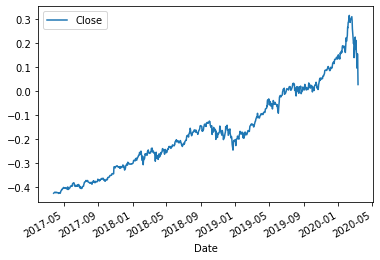

In [40]:
train.loc[dataset['Ticker']=='MSFT', ['Date', 'Close']].set_index('Date').plot()

<AxesSubplot:xlabel='Date'>

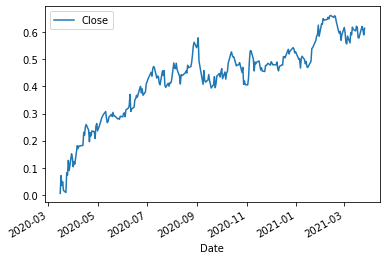

In [41]:
test.loc[dataset['Ticker']=='MSFT', ['Date', 'Close']].set_index('Date').plot()

### Convert one stock into x and y format for input to model

In [42]:

def apply_rolling(stock, trail_size):
    x = []
    y = []
    for i in range(trail_size, len(stock) + 1 - predict_length):
        x_point = stock.drop(columns=['Date', 'Ticker']).iloc[i-trail_size : i].values
        y_point = stock['Close'].iloc[i + predict_length -1]
        
        if np.isnan(x_point).sum() ==0:
            x.append(x_point)
            y.append(y_point)
    
    return np.array(x), np.array(y)

In [43]:
x, y = apply_rolling(dataset.loc[dataset['Ticker']=='AAPL'], trail_size=3)

In [44]:
dataset.loc[dataset['Ticker']=='AAPL']

,Ticker,Date,Close,High,Low,Open,Volume,HH,LL,AV,SMA,SD,WILLR,ATR,DMH,DML,EMA,WMA,BBHIGH,BBLOW,PERBHIGH,PERBLOW,TRIMA,RSI,DX,PDI,NDI,ADX,ROC,MACD,CCI
0,AAPL,2017-03-27,-0.590134,-0.589694,-0.590242,-0.593911,4.525745,-0.586392,-0.583878,4.320309,-0.586038,NaN,0.583985,-0.483696,-0.053648,-0.086946,-0.586248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.078075,-0.130359,NaN,-0.275185,-0.256591,NaN
1,AAPL,2017-03-28,-0.586023,-0.585786,-0.587384,-0.591773,6.600219,-0.582637,-0.583878,5.315855,-0.583978,-0.443266,0.693009,-0.463242,0.325003,0.163902,-0.584037,NaN,-0.575292,-0.584867,0.659212,0.659212,NaN,NaN,-0.293567,1.192464,0.714765,-0.743771,-0.002844,-0.252008,-0.303143
2,AAPL,2017-03-29,-0.585572,-0.585163,-0.583712,-0.587876,5.714349,-0.582038,-0.583878,5.364282,-0.583140,-0.456932,0.307164,-0.491679,0.006776,0.235395,-0.583132,NaN,-0.575246,-0.583131,0.967142,0.967142,NaN,NaN,0.528743,0.172037,1.209327,-0.438907,0.027000,-0.250024,-0.021489
3,AAPL,2017-03-30,-0.585840,-0.585149,-0.583269,-0.587158,4.024511,-0.582025,-0.583878,4.983017,-0.582789,-0.468910,-0.206309,-0.509640,-0.052302,-0.048062,-0.582767,NaN,-0.575564,-0.582018,1.323952,1.323952,NaN,NaN,0.892695,-0.071542,0.059220,-0.247331,0.009281,-0.249726,-0.008948
4,AAPL,2017-03-31,-0.586220,-0.585468,-0.583969,-0.587820,3.697327,-0.582025,-0.583878,4.691452,-0.582654,-0.478178,-0.051785,-0.517822,-0.084534,-0.148409,-0.582650,NaN,-0.575939,-0.581303,1.686771,1.686771,NaN,NaN,0.001694,-0.240886,-0.455664,-0.316709,-0.015903,-0.250429,-0.153295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,AAPL,2021-03-22,-0.056869,-0.062547,-0.064616,-0.077097,5.457799,-0.061109,-0.055365,5.936279,-0.062154,-0.060707,0.580031,0.186228,1.326177,0.219429,-0.054285,-0.074219,-0.065563,-0.051344,0.184811,0.184811,-0.056586,-0.493022,0.395636,0.791413,0.063486,-0.604761,-0.456862,-0.976266,-0.189280
1004,AAPL,2021-03-23,-0.061909,-0.060388,-0.053302,-0.059324,4.587488,-0.061109,-0.055365,5.874733,-0.061950,-0.058466,-0.637253,0.159664,0.155585,0.906129,-0.054504,-0.074563,-0.065250,-0.051265,0.178595,0.178595,-0.059189,-0.578156,0.481013,0.058303,0.519553,-0.551926,-0.223513,-0.933209,0.064360
1005,AAPL,2021-03-24,-0.076435,-0.068207,-0.065759,-0.062345,4.220391,-0.061109,-0.055365,5.552750,-0.061967,-0.058059,-0.967252,0.127396,-0.811417,-1.180387,-0.056638,-0.073384,-0.065244,-0.051308,0.177366,0.177366,-0.061339,-0.814173,-0.225611,-0.593500,-0.877124,-0.551449,-0.279560,-0.950621,-0.332240
1006,AAPL,2021-03-25,-0.073471,-0.075443,-0.072198,-0.081778,4.766237,-0.061109,-0.055365,5.354122,-0.062319,-0.054798,0.095511,0.101732,-0.754868,-0.652155,-0.058091,-0.073272,-0.065398,-0.051885,0.167166,0.167166,-0.063090,-0.751411,-0.442814,-0.572152,-0.530220,-0.563855,-0.365004,-0.946376,-0.585436


In [46]:
x.shape

(987, 3, 29)

In [47]:
y.shape

(987,)

### Convert all stocks into x and y for model input

In [48]:
def roll_all_stocks(dataset, trail_size):
    res = dataset.groupby('Ticker').apply(lambda x: apply_rolling(x, trail_size=trail_size))
    x = [x[0] for x in res.values]
    y = [x[1] for x in res.values]
    return np.concatenate(x), np.concatenate(y)

In [49]:
x_train, y_train = roll_all_stocks(train, trail_size)

In [50]:
x_test, y_test = roll_all_stocks(test, trail_size)

In [51]:
x_test.shape

(2430, 14, 29)

In [52]:
y_test.shape

(2430,)

In [53]:
np.isnan(x_train).sum() == 0 and np.isnan(x_test).sum() and np.isnan(y_test).sum() and np.isnan(y_train).sum()

0

### Model Design

In [54]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.4))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [55]:
model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(50, activation='relu'))
# model.add(Dense(25, activation='relu'))
model.add(Dense(1))

In [56]:
# model = Sequential()
# model.add(Dense(100, input_shape=(trail_size, num_features), activation='relu'))
# model.add(Dropout(0.1))

# model.add(Flatten())

# model.add(Dense(50, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.1))

# # model.add(Dense(50, activation='relu'))
# # model.add(Dense(25, activation='relu'))
# model.add(Dense(1, activation='linear'))

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 14, 75)            31500     
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 75)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 420)              

In [58]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [59]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [60]:
history = model.fit(x_train, y_train, epochs=80, validation_data=(x_test, y_test), batch_size=64, shuffle=False, callbacks=[tensorboard])

Epoch 1/80
112/112 [==============================] - 15s 54ms/step - loss: 0.0995 - val_loss: 0.2288
Epoch 2/80
112/112 [==============================] - 2s 16ms/step - loss: 0.0298 - val_loss: 0.3562
Epoch 3/80
112/112 [==============================] - 2s 15ms/step - loss: 0.0221 - val_loss: 0.3281
Epoch 4/80
112/112 [==============================] - 2s 15ms/step - loss: 0.0182 - val_loss: 0.2619
Epoch 5/80
112/112 [==============================] - 2s 16ms/step - loss: 0.0154 - val_loss: 0.2220
Epoch 6/80
112/112 [==============================] - 2s 15ms/step - loss: 0.0142 - val_loss: 0.2001
Epoch 7/80
112/112 [==============================] - 2s 16ms/step - loss: 0.0146 - val_loss: 0.2422
Epoch 8/80
112/112 [==============================] - 2s 15ms/step - loss: 0.0130 - val_loss: 0.1707
Epoch 9/80
112/112 [==============================] - 2s 15ms/step - loss: 0.0135 - val_loss: 0.1462
Epoch 10/80
112/112 [==============================] - 2s 15ms/step - loss: 0.0115 - val_l

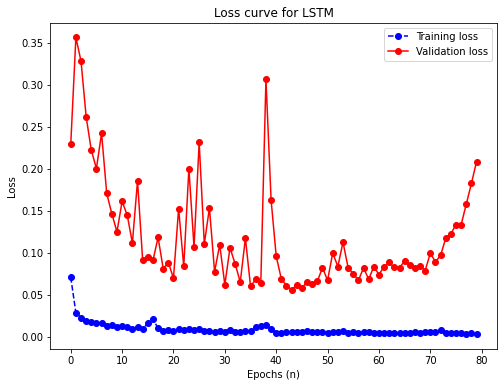

In [61]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.title("Loss curve for LSTM")
plt.show()

In [62]:
def evaluate_model_rmse(y_preds, y_true):
    dummies = np.zeros((y_preds.shape[0], num_features-1))
    res = np.concatenate([y_preds, dummies], axis=1)
    pred_dollars = sc.inverse_transform(res)[:, 0]
    
    res2 = np.concatenate([np.expand_dims(y_true, axis=1), dummies], axis=1)
    true_dollars = sc.inverse_transform(res2)[:, 0]
    return np.sqrt(mean_squared_error(true_dollars, pred_dollars))

In [63]:
model.predict(x_train).shape

(7126, 1)

In [64]:
np.zeros((y_train.shape[0], num_features-1)).shape

(7126, 28)

In [65]:
model.predict(x_train).shape

(7126, 1)

In [66]:
y_train.shape

(7126,)

In [67]:
x_train.shape

(7126, 14, 29)

In [68]:
print("Training RMSE = {}".format(evaluate_model_rmse(model.predict(x_train), y_train)))

Training RMSE = 9.43472112588988


In [69]:
print("Testing RMSE = {}".format(evaluate_model_rmse(model.predict(x_test), y_test)))

Testing RMSE = 76.98841051378197


#### Compare to simple baseline

In [70]:
def predict_no_change(x):
    return x[-1][0]

In [71]:
no_change_preds = np.array([predict_no_change(x) for x in x_train])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [72]:
evaluate_model_rmse(no_change_preds, y_train)

7.000882722501892

In [73]:
no_change_preds = np.array([predict_no_change(x) for x in x_test])
no_change_preds = np.expand_dims(no_change_preds, axis=1)

In [74]:
evaluate_model_rmse(no_change_preds, y_test)

14.161752132429312